In [ ]:
# import the necessary Libraries 
import sys
import requests
import json

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


import io
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans

In [ ]:
response_obj = requests.get('https://en.wikipedia.org/wiki/Special_wards_of_Tokyo').text
soup = BeautifulSoup(response_obj,'lxml')
Wards_Tokyo_Table = soup.find('table', {'class':'wikitable sortable'})
### preparation of the table 

Name=[]
Kanji = []
Pop = []
Density = []
num = []
flag = []
Area = []
Major_District = []

for row in Wards_Tokyo_Table.findAll("tr"):
    #print (row)    
    Ward = row.findAll('td')
    #print (len(Ward))
    print (Ward)
    if len(Ward)==8: #Only extract table body not heading
        print (Ward[0])
        #print postcode[1]
        #print postcode[2]
        num.append(Ward[0].find(text=True))
        flag.append(Ward[1].findAll('a')) # useless
        Name.append(Ward[2])
        Kanji.append(Ward[3].find(text=True))
        Pop.append(Ward[4])
        Area.append(Ward[5].find(text=True))
        Major_District.append(Ward[7].find(text=True))
            
#print (Pop) 


#++++++++++++++++++++++++++++++++++++++++++++++
#+ Area 
#++++++++++++++++++++++++++++++++++++++++++++++

# print (Area[3]) # the first element of the area needs a replacement with the true value 5100
Area = ['5100' if x=='0' else x for x in Area]
New_Area = []

# change the type of Area list 
for l in range(len(Area)):
    x=Area[l].replace(",","")
    print (x)
    New_Area.append(x)

New_Area=[int(s) for s in New_Area]

#print (New_Area) # the list elements are already in accordance with the table

#+++++++++++++++++++++++++++++++++++++++++++++++++++++
#+ Name of the Wards
#+++++++++++++++++++++++++++++++++++++++++++++++++++++
#print (Name) # want to select only the title part

new_names = []
for n in range(len(Name)):
    print (Name[n])
    names = Name[n].findAll('a')
    new_names.append(names) 

print (new_names)

flat_new_names_list = [item for sublist in new_names for item in sublist]
print (flat_new_names_list)

Wards_names= []
#now 
for name_wards in flat_new_names_list:
        Wards_names.append(name_wards.get('title'))

print (Wards_names)

# replace the elements in the list that contains 'Tokyo' with only the ward names
replace_names={'Chiyoda, Tokyo':'Chiyoda', 'Chūō, Tokyo':'Chuo', 'Minato, Tokyo':'Minato', 
               'Sumida, Tokyo':'Sumida', 'Koto, Tokyo':'Koto', 'Ōta, Tokyo':'Ota', 'Nakano, Tokyo':'Nakano', 'Bunkyō, Tokyo':'Bunkyo',
               'Taitō':'Taito', 'Kita, Tokyo':'Kita', 'Arakawa, Tokyo':'Arakawa', 'Adachi, Tokyo':'Adachi', 'Edogawa, Tokyo':'Edogawa'}


Wards_names1 = [replace_names.get(n1,n1) for n1 in Wards_names]

#print (Wards_names1)

#+++++++++++++++++++++++++++++++++++++++++++++++++++++
#+ Population
#+++++++++++++++++++++++++++++++++++++++++++++++++++++
# print (len(Pop))
# #print ((Pop[5].text))
population = []
for p in range(len(Pop)):
    print ((Pop[p]))
    pops = Pop[p].text[1:9]
    print (Pop[p].text[1:9])
    #populs = Pop[p].find('visibility:hidden;color:transparent;')
    population.append(pops) 
print (population)


New_population = []
for po in range(len(population)):
    xy=population[po].replace(",","")
    print (xy)
    New_population.append(xy)

New_population=[int(s1) for s1 in New_population]
# print (New_population)



#++++++++++++++++++++++++++++++++++++++++++++++++
#+ Major Districts
#++++++++++++++++++++++++++++++++++++++++++++++++


replace_districts = {'Nagatachō':'Nagatacho', 'Hongō':'Hongo', 'Kinshichō':'Kinshicho', 'Ōmori': 'Omori',
                     'Kōenji':'Koenji', 'Arakawa, Machiya, ':'Arakawa', 'Ayase, ':'Ayase', 'Kasai, Koiwa\n':'Kasai'}


Major_District_names1 = [replace_districts.get(n2,n2) for n2 in Major_District]

df=pd.DataFrame(Wards_names1,columns=['Ward'])
df['Area_SqKm'] = New_Area
df['Population'] = New_population
df['Major_District'] = Major_District_names1
df.index = np.arange(1, len(df) + 1) # reset the index so that it starts from 1. 

# use of geopy geocoders
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Tokyo_explorer")
df['Major_Dist_Coord']= df['Major_District'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df[['Latitude', 'Longitude']] = df['Major_Dist_Coord'].apply(pd.Series)

df.drop(['Major_Dist_Coord'], axis=1, inplace=True)
# replace some of the wrong coordinates 


Lat_list = df['Latitude'].tolist()
Long_list = df['Longitude'].tolist()
print ("Old latitude list: ", Lat_list)
print ("Old Longitude list: ", Long_list)
replace_latitudes = {32.5093796:35.7088, 23.0131338:35.6722, -38.9047057:35.5884, -5.3498001:35.6634}
replace_longitudes = {-116.2970014:139.7601, -80.8328748:139.8061, 175.7552111:139.7279, 21.424098:139.8731}

latitudes_new = [replace_latitudes.get(n3,n3) for n3 in Lat_list]
longtitudes_new = [replace_longitudes.get(n4,n4) for n4 in Long_list]
print (latitudes_new)
print (longtitudes_new)

Tokyo_df = df.drop(['Latitude', 'Longitude'], axis=1)
# #df.drop(['Longitude'], axis=1, inplace=True)
# Tokyo_df


Tokyo_df['Dist_Latitude'] = latitudes_new
Tokyo_df['Dist_Longitude'] = longtitudes_new

#Tokyo_df

Tokyo_df.to_csv('Tokyo_df_Coord.csv')    

[]
[<td>01</td>, <td><a class="image" href="/wiki/File:Flag_of_Chiyoda,_Tokyo.svg"><img alt="Flag of Chiyoda, Tokyo.svg" class="thumbborder" data-file-height="540" data-file-width="810" decoding="async" height="33" src="//upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Flag_of_Chiyoda%2C_Tokyo.svg/50px-Flag_of_Chiyoda%2C_Tokyo.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Flag_of_Chiyoda%2C_Tokyo.svg/75px-Flag_of_Chiyoda%2C_Tokyo.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Flag_of_Chiyoda%2C_Tokyo.svg/100px-Flag_of_Chiyoda%2C_Tokyo.svg.png 2x" width="50"/></a></td>, <td><a href="/wiki/Chiyoda,_Tokyo" title="Chiyoda, Tokyo">Chiyoda</a></td>, <td>千代田区
</td>, <td><span style="visibility:hidden;color:transparent;">0</span><span style="visibility:hidden;color:transparent;">0</span>59,441</td>, <td><span style="visibility:hidden;color:transparent;">0</span>5,100</td>, <td><span style="visibility:hidden;color:transparent;">0</span>11.66
</td>, <t

In [ ]:
Tokyo_df = pd.read_csv('Tokyo_df_Coord.csv', index_col=[0])
#remove the unnamed column 
Tokyo_df.head(20)

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude
1,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469
2,Chuo,14460,147620,Nihonbashi,35.684068,139.774503
3,Minato,12180,248071,Odaiba,35.626722,139.772101
4,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632
5,Bunkyō,19790,223389,Hongo,35.175376,137.013476
6,Taito,19830,200486,Ueno,35.711795,139.776075
7,Sumida,18910,260358,Kinshicho,35.696312,139.815043
8,Koto,12510,502579,Kiba,35.672200,139.806100
9,Shinagawa,17180,392492,Shinagawa,35.599252,139.738910
10,Meguro,19110,280283,Meguro,35.621250,139.688014


In [ ]:
response_obj = requests.get('https://utinokati.com/en/details/land-market-value/area/Tokyo/').text
print (type (response_obj))
soup = BeautifulSoup(response_obj,'lxml')
print (soup.prettify())

<class 'str'>
<!DOCTYPE html>
<html content="en" id="utinokati">
 <head>
  <meta charset="utf-8"/>
  <meta content="en" http-equiv="content-language"/>
  <link href="https://utinokati.com/en/details/land-market-value/area/Tokyo/" rel="canonical"/>
  <meta content="Tokyo,land market value,real estate market value" name="keywords"/>
  <meta content=" The Tokyo Land market price is 489,177 JPY/sq.m. You can easily calculate the assumed price from the station distance, area etc." name="description"/>
  <meta content="ウチノカチ" name="author"/>
  <title>
   Tokyo Land market value
  </title>
  <meta content="Tokyo Land market value" property="og:title"/>
  <meta content=" The Tokyo Land market price is 489,177 JPY/sq.m. You can easily calculate the assumed price from the station distance, area etc." property="og:description"/>
  <meta content="https://utinokati.com/rectangle/en/details/land-market-value/area/Tokyo/thumb.png" property="og:image"/>
  <meta content="https://utinokati.com/en/detail

In [ ]:
Price_Tokyo_Table = soup.find('tbody')
#Price_Tokyo_Table

In [ ]:
Name=[]
Avg_price = []


for row in Price_Tokyo_Table.findAll("tr"):
    
    price = row.findAll('td')
    Name.append(price[0].find(text=True))
    Avg_price.append(price[2].find(text=True))   

print(Name)

price_df = pd.DataFrame(Name,columns=['Ward'])
price_df['Avg_price_sqKm'] = Avg_price




price_df['Avg_price_sqKm'] = price_df['Avg_price_sqKm'].map(lambda x: x.rstrip('JPY/sq.m').rstrip('0123456789'))

#print (price_df.dtypes)
# Change the average price column datatype 
Avg_price_list = price_df['Avg_price_sqKm'].tolist()
New_Avg_price = []

for pr in range(len(Avg_price_list)):
    x = Avg_price_list[pr].replace(",", "")
    New_Avg_price.append(x)


Avg_price_new=[int(s) for s in New_Avg_price]

price_df.drop(['Avg_price_sqKm'], axis=1, inplace=True)

price_df['Average_Price(SqKm)'] = New_Avg_price

price_df

['Chiyoda-Ku', 'Chuo-Ku', 'Minato-Ku', 'Shinjuku-Ku', 'Bunkyo-Ku', 'Taito-Ku', 'Sumida-Ku', 'Koto-Ku', 'Shinagawa-Ku', 'Meguro-Ku', 'Ota-Ku', 'Setagaya-Ku', 'Shibuya-Ku', 'Nakano-Ku', 'Suginami-Ku', 'Toshima-Ku', 'Kita-Ku', 'Arakawa-Ku', 'Itabashi-Ku', 'Nerima-Ku', 'Adachi-Ku', 'Katsushika-Ku', 'Edogawa-Ku', 'Hachioji-Shi', 'Tachikawa-Shi', 'Musashino-Shi', 'Mitaka-Shi', 'Ome-Shi', 'Fuchu-Shi', 'Akishima-Shi', 'Chofu-Shi', 'Machida-Shi', 'Koganei-Shi', 'Kodaira-Shi', 'Hino-Shi', 'Higashimurayama-Shi', 'Kokubunji-Shi', 'Kunitachi-Shi', 'Fussa-Shi', 'Komae-Shi', 'Higashiyamato-Shi', 'Kiyose-Shi', 'Higashikurume-Shi', 'Musashimurayama-Shi', 'Tama-Shi', 'Inagi-Shi', 'Hamura-Shi', 'Akiruno-Shi', 'Nishitokyo-Shi', 'Nishitama-Gun', 'Oshima-Machi', 'Niijima-Mura', 'Kozushima-Mura', 'Ogasawara-Mura']


,Ward,Average_Price(SqKm)
0,Chiyoda-Ku,2705898
1,Chuo-Ku,2699719
2,Minato-Ku,2121252
3,Shinjuku-Ku,939286
4,Bunkyo-Ku,945155
5,Taito-Ku,1064759
6,Sumida-Ku,617190
7,Koto-Ku,658047
8,Shinagawa-Ku,767398
9,Meguro-Ku,863712


In [ ]:
## Select info only for 5 relevant wards Chiyoda, Chuo, Shinjuku, Shibuya, Shinagawa. 
## 
pd.options.mode.chained_assignment = None
ward_list = ['Chiyoda-Ku', 'Chuo-Ku', 'Minato-Ku', 'Shibuya-Ku', 'Taito-Ku', 'Shinjuku-Ku', 'Meguro-Ku', 'Shinagawa-Ku']
price_df_selected = price_df.loc[price_df['Ward'].isin(ward_list)]
price_df_selected.index = np.arange(1, len(price_df_selected) + 1)
#Ward_names = price_df_selected['Ward'].map(lambda y: str(y)[:-3]) # strip -Ku from the ward names
price_df_selected['Ward']=price_df_selected['Ward'].map(lambda y: str(y)[:-3]) 
#price_df_selected.drop(['Ward'], axis=1, inplace=True)
#price_df_selected['Ward']=Ward_names
price_df_selected

,Ward,Average_Price(SqKm)
1,Chiyoda,2705898
2,Chuo,2699719
3,Minato,2121252
4,Shinjuku,939286
5,Taito,1064759
6,Shinagawa,767398
7,Meguro,863712
8,Shibuya,1360332


In [ ]:
## Similarly select those five wards from the Tokyo Wards Data-Frame
ward_list1 = ['Chiyoda', 'Chuo', 'Minato',  'Taito', 'Shibuya', 'Shinjuku', 'Meguro', 'Shinagawa']
Tokyo_df_selected = Tokyo_df.loc[Tokyo_df['Ward'].isin(ward_list1)]
Tokyo_df_selected

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude
1,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469
2,Chuo,14460,147620,Nihonbashi,35.684068,139.774503
3,Minato,12180,248071,Odaiba,35.626722,139.772101
4,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632
6,Taito,19830,200486,Ueno,35.711795,139.776075
9,Shinagawa,17180,392492,Shinagawa,35.599252,139.738910
10,Meguro,19110,280283,Meguro,35.621250,139.688014
13,Shibuya,15080,227850,Shibuya,35.664596,139.698711


In [ ]:
# Merge the two dataframes according to the ward names 

Tokyo_df_selected_final = Tokyo_df_selected.merge(price_df_selected, on='Ward', how='left')
Tokyo_df_selected_final.index = np.arange(1, len(Tokyo_df_selected_final)+1)
Tokyo_df_selected_final.to_csv('Tokyo_8_Wards.csv')
Tokyo_df_selected_final

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm)
1,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469,2705898
2,Chuo,14460,147620,Nihonbashi,35.684068,139.774503,2699719
3,Minato,12180,248071,Odaiba,35.626722,139.772101,2121252
4,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632,939286
5,Taito,19830,200486,Ueno,35.711795,139.776075,1064759
6,Shinagawa,17180,392492,Shinagawa,35.599252,139.738910,767398
7,Meguro,19110,280283,Meguro,35.621250,139.688014,863712
8,Shibuya,15080,227850,Shibuya,35.664596,139.698711,1360332


In [ ]:
# get Tokyo, Tokyo Latitude and Longitude 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Tokyo'

geolocator = Nominatim(user_agent="Tokyo_explorer")
location = geolocator.geocode(address)
Tokyo_latitude = location.latitude
Tokyo_longitude = location.longitude
print('The geograpical coordinates of Tokyo are {}, {}.'.format(Tokyo_latitude, Tokyo_longitude))

The geograpical coordinates of Tokyo are 35.6828387, 139.7594549.


In [ ]:
import folium
# # create map of Most Busy Office Areas of Tokyo using latitude and longitude values
Tokyo_8Wards = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(Tokyo_df_selected_final['Dist_Latitude'], Tokyo_df_selected_final['Dist_Longitude'], 
                           Tokyo_df_selected_final['Major_District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        color='magenta',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(Tokyo_8Wards)  
    
Tokyo_8Wards

In [ ]:
CLIENT_ID = '2R0O1ABYVJOS34IWLRYY5DC2FTRS5OOXTZGNNSXPPYPPH3GH' #'your-client-ID' # your Foursquare ID
CLIENT_SECRET = 'HUI1E1KKIIOGWVRVBKVV3GEAX51RMZQ3BHMUZQK3E43IIJDO' #'your-client-secret' # your Foursquare Secret
VERSION = '20200831' # Foursquare API version

print('My credentails:')
print('My CLIENT_ID: ' + CLIENT_ID)
print('My CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
My CLIENT_ID: 2R0O1ABYVJOS34IWLRYY5DC2FTRS5OOXTZGNNSXPPYPPH3GH
My CLIENT_SECRET:HUI1E1KKIIOGWVRVBKVV3GEAX51RMZQ3BHMUZQK3E43IIJDO


In [ ]:
radius = 1000
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Dist_Latitude', 
                  'Dist_Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

In [ ]:
Tokyo_8_Dist_Venues = getNearbyVenues(names=Tokyo_df_selected_final['Major_District'],
                                   latitudes=Tokyo_df_selected_final['Dist_Latitude'],
                                   longitudes=Tokyo_df_selected_final['Dist_Longitude']
                                  )

Nagatacho
Nihonbashi
Odaiba
Shinjuku
Ueno
Shinagawa
Meguro
Shibuya


In [ ]:
print ("Shape of the Venues Dataframe: ", Tokyo_8_Dist_Venues.shape)
Tokyo_8_Dist_Venues.tail(100)

Shape of the Venues Dataframe:  (800, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
700,Shibuya,35.664596,139.698711,LINE CUBE SHIBUYA,35.664100,139.698520,Concert Hall
701,Shibuya,35.664596,139.698711,THE SG CLUB,35.664284,139.699167,Cocktail Bar
702,Shibuya,35.664596,139.698711,Au Temps Jadis Creperie,35.664938,139.700416,Café
703,Shibuya,35.664596,139.698711,Kenyan (ケニヤン),35.663838,139.699920,Tea Room
704,Shibuya,35.664596,139.698711,koé lobby,35.662535,139.698978,Café
...,...,...,...,...,...,...,...
795,Shibuya,35.664596,139.698711,Tenkazushi (天下寿司),35.658970,139.698025,Sushi Restaurant
796,Shibuya,35.664596,139.698711,pivoine,35.666129,139.692082,Women's Store
797,Shibuya,35.664596,139.698711,restaurant eatrip,35.668345,139.704395,Restaurant
798,Shibuya,35.664596,139.698711,NUMBER SUGAR,35.666434,139.706014,Candy Store


In [ ]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

Tokyo_8_Dist_Venues_only_restaurant = Tokyo_8_Dist_Venues[Tokyo_8_Dist_Venues['Venue_Category']\
                                                          .str.contains('Restaurant')].reset_index(drop=True)
Tokyo_8_Dist_Venues_only_restaurant.index = np.arange(1, len(Tokyo_8_Dist_Venues_only_restaurant)+1)
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", Tokyo_8_Dist_Venues_only_restaurant.shape)
Tokyo_8_Dist_Venues_only_restaurant.head(100)

Shape of the Data-Frame with Venue Category only Restaurant:  (261, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
1,Nagatacho,35.675618,139.743469,Nagatacho Kurosawa (永田町 黒澤),35.674699,139.741737,Japanese Restaurant
2,Nagatacho,35.675618,139.743469,Shinamen Hashigo (支那麺 はしご),35.672184,139.741576,Ramen Restaurant
3,Nagatacho,35.675618,139.743469,Sushi Isshin (鮨 一新),35.672589,139.739399,Sushi Restaurant
4,Nagatacho,35.675618,139.743469,Kisurin (希須林),35.674514,139.737969,Ramen Restaurant
5,Nagatacho,35.675618,139.743469,All Day Dining Origami (オールデイダイニング ORIGAMI),35.673815,139.741104,Restaurant
...,...,...,...,...,...,...,...
96,Odaiba,35.626722,139.772101,bills,35.629587,139.776393,Australian Restaurant
97,Odaiba,35.626722,139.772101,Ganja Next Level (頑者 NEXT LEVEL),35.628152,139.773669,Ramen Restaurant
98,Odaiba,35.626722,139.772101,Gundam Café (ガンダムカフェ),35.624801,139.775750,Theme Restaurant
99,Odaiba,35.626722,139.772101,Pomme's (ポムの樹),35.626985,139.772598,Yoshoku Restaurant


In [ ]:
## Show in Map the Top Rated Restaruants in the Top 5 Districts

map_restaurants = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=11, tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the Venues based on the Major Districts
Districts = ['Nagatacho', 'Nihonbashi', 'Odaiba', 'Ueno', 'Shinjuku', 'Shinagawa', 'Meguro', 'Shibuya']

x = np.arange(len(Districts))

rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000','#008015', '#6600cc','#ffff00']

# add markers to the map
# markers_colors = []
for lat, lon, poi, distr in zip(Tokyo_8_Dist_Venues_only_restaurant['Venue_Lat'], 
                                  Tokyo_8_Dist_Venues_only_restaurant['Venue_Long'], 
                                  Tokyo_8_Dist_Venues_only_restaurant['Venue_Category'], 
                                  Tokyo_8_Dist_Venues_only_restaurant['District']):
    label = folium.Popup(str(poi) + ' ' + str(distr), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[Districts.index(distr)-1],
        fill=True,
        fill_color=rainbow[Districts.index(distr)-1],
        fill_opacity=0.3).add_to(map_restaurants)
       
map_restaurants

In [ ]:
### Number of Unique Categories in the Dataframe 
print('There are {} unique categories.'.format(len(Tokyo_8_Dist_Venues['Venue_Category'].unique())))
## We can check some of the categories randomly  
print (Tokyo_8_Dist_Venues[['Venue_Category']][70:75])

There are 168 unique categories.
         Venue_Category
70                Hotel
71          Coffee Shop
72  Japanese Restaurant
73     Sushi Restaurant
74      Soba Restaurant


In [ ]:
print (Tokyo_8_Dist_Venues['Venue_Category'].value_counts())

Sake Bar                 37
BBQ Joint                36
Japanese Restaurant      36
Café                     30
Convenience Store        29
                         ..
Sauna / Steam Room        1
Shoe Store                1
General Entertainment     1
Sandwich Place            1
Karaoke Bar               1
Name: Venue_Category, Length: 168, dtype: int64


In [ ]:
# create a dataframe of top 10 categories
Tokyo_8_Dist_Venues_Top10 = Tokyo_8_Dist_Venues['Venue_Category'].value_counts()[0:10].to_frame(name='frequency')
Tokyo_8_Dist_Venues_Top10=Tokyo_8_Dist_Venues_Top10.reset_index()
#Tokyo_8_Dist_Venues_Top10

Tokyo_8_Dist_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Tokyo_8_Dist_Venues_Top10

,Venue_Category,Frequency
0,Sake Bar,37
1,BBQ Joint,36
2,Japanese Restaurant,36
3,Café,30
4,Convenience Store,29
5,Coffee Shop,28
6,Ramen Restaurant,28
7,Sushi Restaurant,19
8,Chinese Restaurant,19
9,Hotel,18


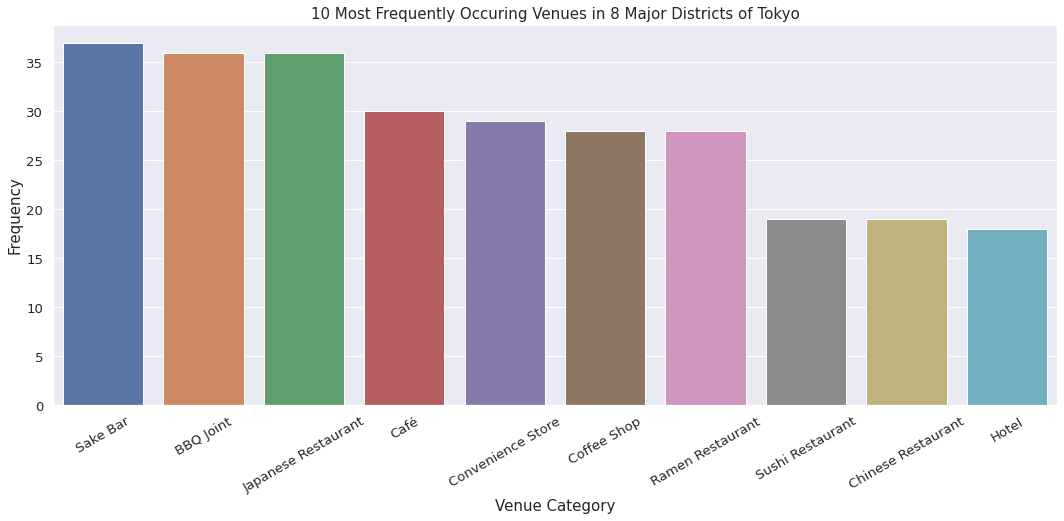

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Tokyo_8_Dist_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues in 8 Major Districts of Tokyo', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

In [ ]:
### Use One Hot Encoding to Get More Information about the Venue Categories 
Tokyo_8_Dist_Venues_onehot = pd.get_dummies(Tokyo_8_Dist_Venues[['Venue_Category']], prefix="", prefix_sep="")

### add district column back to dataframe
Tokyo_8_Dist_Venues_onehot['District'] = Tokyo_8_Dist_Venues['District'] 
### move district column to the first column
fixed_columns = [Tokyo_8_Dist_Venues_onehot.columns[-1]] + list(Tokyo_8_Dist_Venues_onehot.columns[:-1])
Tokyo_8_Dist_Venues_onehot = Tokyo_8_Dist_Venues_onehot[fixed_columns]
###Tokyo_8_Dist_Venues_onehot.head(3)

In [ ]:
Tokyo_8_Dist_Venues_Grouped = Tokyo_8_Dist_Venues_onehot.groupby('District').mean().reset_index()
Tokyo_8_Dist_Venues_Grouped.index = np.arange(1, len(Tokyo_8_Dist_Venues_Grouped)+1)
Tokyo_8_Dist_Venues_Grouped

,District,Accessories Store,African Restaurant,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Auditorium,Australian Restaurant,BBQ Joint,Bakery,Bar,Bath House,Beach,Bed & Breakfast,Beer Bar,Bistro,Bookstore,Boutique,Brazilian Restaurant,Bubble Tea Shop,Buffet,Burger Joint,Bus Stop,Café,Camera Store,Canal,Candy Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,...,Skate Park,Smoke Shop,Soba Restaurant,Soccer Field,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Takoyaki Place,Tapas Restaurant,Tea Room,Teishoku Restaurant,Tempura Restaurant,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Tonkatsu Restaurant,Toy / Game Store,Trail,Train Station,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Wagashi Place,Whisky Bar,Wine Bar,Women's Store,Yakitori Restaurant,Yoshoku Restaurant
1,Meguro,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.03,0.00,0.01,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.01,0.00,0.00,0.04,0.00,0.00,0.00,0.07,0.00,0.00,0.11,0.00,0.00,0.00,0.03,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00
2,Nagatacho,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.08,0.01,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.07,0.01,0.01,0.00,0.00,0.00,0.00,0.03,...,0.00,0.00,0.02,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.03,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.03,0.02
3,Nihonbashi,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.05,0.04,0.02,0.00,0.00,0.01,0.02,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.04,...,0.00,0.00,0.03,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.04,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.02,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.02,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.02
4,Odaiba,0.00,0.00,0.03,0.00,0.02,0.01,0.01,0.01,0.02,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.02,0.00,0.02,0.00,0.00,0.01,0.00,0.01,0.01,0.00,0.03,0.00,0.00,0.03,0.00,0.00,0.00,0.00,...,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.02,0.00,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.01,0.00,0.02,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01
5,Shibuya,0.01,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.02,0.01,0.03,0.00,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.00,0.00,0.01,0.00,0.10,0.00,0.00,0.01,0.02,0.01,0.01,0.01,0.05,0.01,0.02,0.00,0.00,0.00,0.00,0.01,...,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.03,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.01,0.00
6,Shinagawa,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.02,0.02,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.02,0.00,0.00,0.15,0.00,0.00,0.00,0.00,...,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.03,0.02
7,Shinjuku,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.01,0.07,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.01,0.01,0.00,0.00,0.01,0.00,0.02,0.01,...,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.02,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.01
8

In [ ]:
num_top_venues = 10

for places in Tokyo_8_Dist_Venues_Grouped['District']:
    print("---------------   "+places+"   ---------------------")
    temp = Tokyo_8_Dist_Venues_Grouped[Tokyo_8_Dist_Venues_Grouped['District'] == places].T.reset_index()
    temp.columns = ['Venue','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---------------   Meguro   ---------------------
                 Venue  Freq
0    Convenience Store  0.11
1          Coffee Shop  0.07
2                 Café  0.06
3  Japanese Restaurant  0.06
4        Grocery Store  0.06
5     Ramen Restaurant  0.04
6   Chinese Restaurant  0.04
7                 Park  0.04
8               Bakery  0.03
9             Sake Bar  0.03


---------------   Nagatacho   ---------------------
                 Venue  Freq
0  Japanese Restaurant  0.09
1            BBQ Joint  0.08
2          Coffee Shop  0.07
3   Chinese Restaurant  0.05
4                Hotel  0.05
5  Szechuan Restaurant  0.04
6    Korean Restaurant  0.03
7         Dessert Shop  0.03
8   Italian Restaurant  0.03
9     Ramen Restaurant  0.03


---------------   Nihonbashi   ---------------------
                 Venue  Freq
0  Japanese Restaurant  0.06
1                 Café  0.06
2            BBQ Joint  0.05
3                Hotel  0.04
4         Dessert Shop  0.04
5           Hobby Shop  0.04
6

In [ ]:
## Define a Function to select the top 10 rows (According to the Values) 

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
District_top10_venues_sorted = pd.DataFrame(columns=columns)
District_top10_venues_sorted['District'] = Tokyo_8_Dist_Venues_Grouped['District']

for ind in np.arange(Tokyo_8_Dist_Venues_Grouped.shape[0]):
    District_top10_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Tokyo_8_Dist_Venues_Grouped.iloc[ind, :], num_top_venues)

    
District_top10_venues_sorted.index = np.arange(1, len(District_top10_venues_sorted)+1)
District_top10_venues_sorted.head(8)

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Meguro,Convenience Store,Coffee Shop,Japanese Restaurant,Grocery Store,Café,Chinese Restaurant,Ramen Restaurant,Park,Dessert Shop,Bakery
2,Nagatacho,Japanese Restaurant,BBQ Joint,Coffee Shop,Hotel,Chinese Restaurant,Szechuan Restaurant,Yakitori Restaurant,Ramen Restaurant,Korean Restaurant,Theater
3,Nihonbashi,Café,Japanese Restaurant,BBQ Joint,Dessert Shop,Hotel,Sushi Restaurant,Hobby Shop,Bakery,Gift Shop,French Restaurant
4,Odaiba,Theme Park,Japanese Restaurant,Shopping Mall,Exhibit,American Restaurant,Discount Store,Park,Italian Restaurant,Coffee Shop,Plaza
5,Shibuya,Café,Record Shop,Coffee Shop,Nightclub,French Restaurant,Bar,Sushi Restaurant,Sake Bar,Stationery Store,Bookstore
6,Shinagawa,Convenience Store,Ramen Restaurant,Sake Bar,BBQ Joint,Sushi Restaurant,Grocery Store,Park,Donburi Restaurant,Yakitori Restaurant,Bar
7,Shinjuku,Sake Bar,BBQ Joint,Bar,Ramen Restaurant,Japanese Restaurant,Pub,Rock Club,Department Store,Movie Theater,Thai Restaurant
8,Ueno,Sake Bar,BBQ Joint,Tonkatsu Restaurant,Japanese Restaurant,Chinese Restaurant,Café,Coffee Shop,Ramen Restaurant,Science Museum,Bed & Breakfast


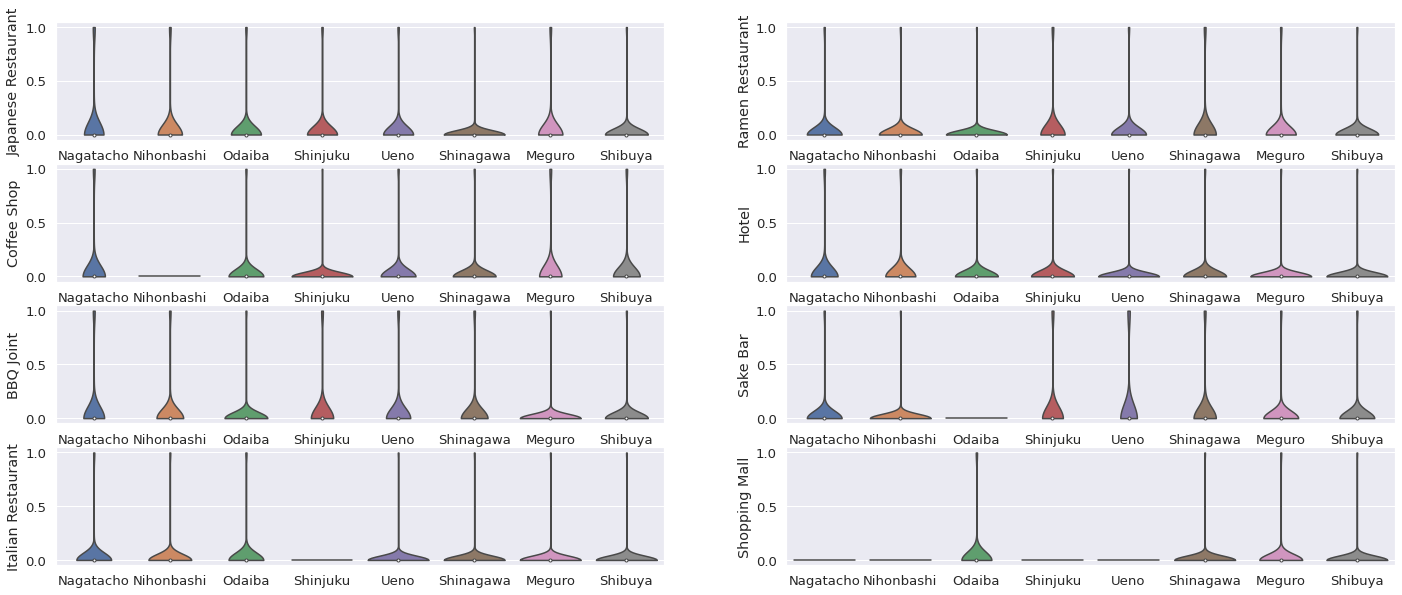

In [ ]:
# Let's try Categorical plot 


fig = plt.figure(figsize=(24,10))

sns.set(font_scale=1.2)
ax = plt.subplot(4,2,1)
sns.violinplot(x="District", y="Japanese Restaurant", data=Tokyo_8_Dist_Venues_onehot, cut=0);
plt.xlabel("")
ax = plt.subplot(4,2,2)
sns.violinplot(x="District", y="Ramen Restaurant", data=Tokyo_8_Dist_Venues_onehot, cut=0);
plt.xlabel("")
plt.subplot(4,2,3)
sns.violinplot(x="District", y="Coffee Shop", data=Tokyo_8_Dist_Venues_onehot, cut=0);
plt.subplot(4,2,4)
sns.violinplot(x="District", y="Hotel", data=Tokyo_8_Dist_Venues_onehot, cut=0);
ax = plt.subplot(4,2,5)
sns.violinplot(x="District", y="BBQ Joint", data=Tokyo_8_Dist_Venues_onehot, cut=0);
plt.xlabel("")
ax = plt.subplot(4,2,6)
sns.violinplot(x="District", y="Sake Bar", data=Tokyo_8_Dist_Venues_onehot, cut=0);
plt.xlabel("")
ax = plt.subplot(4,2,7)
sns.violinplot(x="District", y="Italian Restaurant", data=Tokyo_8_Dist_Venues_onehot, cut=0);
plt.xlabel("")
ax = plt.subplot(4,2,8)
sns.violinplot(x="District", y="Shopping Mall", data=Tokyo_8_Dist_Venues_onehot, cut=0);
plt.xlabel("")
#ax.title.set_text("5 Major Districts and Violin Plots of Most Frequently Visited Restaurants")
#ax.text(-4.0, 1.1, '5 Major Districts and Violin Plots of Most Frequently Visited Restaurants', fontsize=14)
plt.savefig ("Violin_plots_Dist_Frequent_Restaurant.png", dpi=240)
plt.show()

[23, 53, 40, 23, 25, 32, 29, 36]


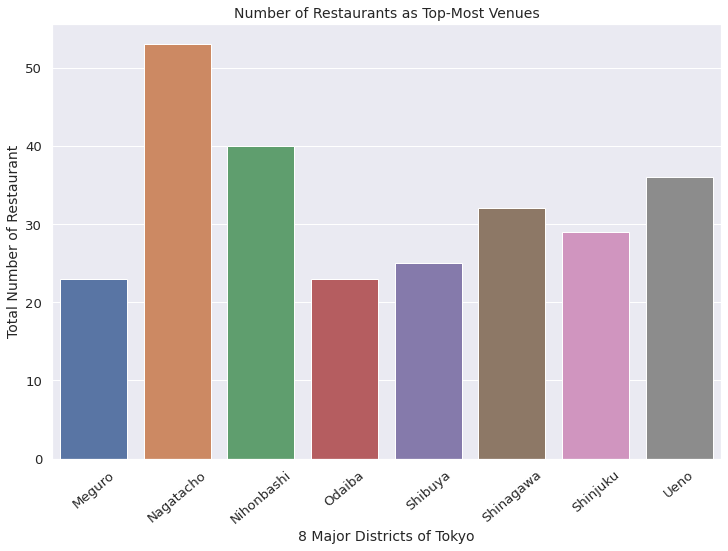

In [ ]:
#try groupby to play with restaurant 
Tokyo_8_Dist_Venues_restaurant = Tokyo_8_Dist_Venues.groupby(['District'])['Venue_Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
Tokyo_8_Dist_Venues_restaurant_df = Tokyo_8_Dist_Venues_restaurant.to_frame().reset_index()
Tokyo_8_Dist_Venues_restaurant_df.columns = ['District', 'Number of Restaurant']
#Tokyo_8_Dist_Venues_restaurant.columns = ['District', 'Number of Restaurant']
#print (type(Tokyo_8_Dist_Venues_restaurant))
Tokyo_8_Dist_Venues_restaurant_df.index = np.arange(1, len(Tokyo_8_Dist_Venues_restaurant_df)+1)

#print ("shape of the dataframe: ", Tokyo_8_Dist_Venues_restaurant_df.shape)
#print (Tokyo_8_Dist_Venues_restaurant_df.head(5))
#print (type(Tokyo_8_Dist_Venues_restaurant_df[['Number of Restaurant']]))
list_rest_no = Tokyo_8_Dist_Venues_restaurant_df['Number of Restaurant'].to_list()
print (list_rest_no)
fig = plt.figure(figsize=(12,8))
bar = sns.barplot(x='District', y='Number of Restaurant', data=Tokyo_8_Dist_Venues_restaurant_df)

bar.set_ylabel("Total Number of Restaurant", fontsize=14)
bar.set_xlabel("8 Major Districts of Tokyo", fontsize=14)
bar.set_xticklabels(bar.get_xticklabels(),rotation=40)
bar.set_title("Number of Restaurants as Top-Most Venues", fontsize=14)
#plt.savefig("No_of_Rest_as_Top_Venues.png", dpi=240)
plt.show()

In [ ]:
# set number of clusters
kclusters = 5

Tokyo_grouped_clustering = Tokyo_8_Dist_Venues_Grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print ("Check the 5 Cluster labels :",  kmeans.labels_[0:8])

Check the 5 Cluster labels : [4 1 1 3 0 4 2 2]


In [ ]:

# add clustering labels

District_top10_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

Tokyo_8_Dist_Coordinate_Cluster_merged = Tokyo_df_selected_final

#merge the inital Tokyo Dataframe with Sorted Most Visited places for each neighborhood

Tokyo_8_Dist_Coordinate_Cluster_merged = Tokyo_8_Dist_Coordinate_Cluster_merged.join \
                                        (District_top10_venues_sorted.set_index('District'), on='Major_District')

Tokyo_8_Dist_Coordinate_Cluster_merged.head()

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469,2705898,1,Japanese Restaurant,BBQ Joint,Coffee Shop,Hotel,Chinese Restaurant,Szechuan Restaurant,Yakitori Restaurant,Ramen Restaurant,Korean Restaurant,Theater
2,Chuo,14460,147620,Nihonbashi,35.684068,139.774503,2699719,1,Café,Japanese Restaurant,BBQ Joint,Dessert Shop,Hotel,Sushi Restaurant,Hobby Shop,Bakery,Gift Shop,French Restaurant
3,Minato,12180,248071,Odaiba,35.626722,139.772101,2121252,3,Theme Park,Japanese Restaurant,Shopping Mall,Exhibit,American Restaurant,Discount Store,Park,Italian Restaurant,Coffee Shop,Plaza
4,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632,939286,2,Sake Bar,BBQ Joint,Bar,Ramen Restaurant,Japanese Restaurant,Pub,Rock Club,Department Store,Movie Theater,Thai Restaurant
5,Taito,19830,200486,Ueno,35.711795,139.776075,1064759,2,Sake Bar,BBQ Joint,Tonkatsu Restaurant,Japanese Restaurant,Chinese Restaurant,Café,Coffee Shop,Ramen Restaurant,Science Museum,Bed & Breakfast


In [ ]:
# create map
map_clusters = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Tokyo_8_Dist_Coordinate_Cluster_merged['Dist_Latitude'], 
                                  Tokyo_8_Dist_Coordinate_Cluster_merged['Dist_Longitude'], 
                                  Tokyo_8_Dist_Coordinate_Cluster_merged['Major_District'], 
                                  Tokyo_8_Dist_Coordinate_Cluster_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
# create map
map_business10 = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], tiles='cartodbpositron', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']
Districts = ['Nagatacho', 'Nihonbashi', 'Odaiba', 'Ueno', 'Shinjuku', 'Shinagawa', 'Meguro', 'Shibuya']

# add markers to the map
for lat, lon, poi, cluster in zip(Tokyo_8_Dist_Coordinate_Cluster_merged['Dist_Latitude'], 
                                  Tokyo_8_Dist_Coordinate_Cluster_merged['Dist_Longitude'], 
                                  Tokyo_8_Dist_Coordinate_Cluster_merged['Major_District'], 
                                  Tokyo_8_Dist_Coordinate_Cluster_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[Districts.index(poi)]*0.5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_business10)
       
map_business10

In [ ]:
Tokyo_Cluster1 = Tokyo_8_Dist_Coordinate_Cluster_merged.loc[Tokyo_8_Dist_Coordinate_Cluster_merged['Cluster Label'] == 0, 
                                    Tokyo_8_Dist_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_8_Dist_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 0: %d" %(Tokyo_Cluster1.shape[0]))
Tokyo_Cluster1

No of Neighbourhood in Cluster Label 0: 1


,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Shibuya,35.664596,139.698711,1360332,0,Café,Record Shop,Coffee Shop,Nightclub,French Restaurant,Bar,Sushi Restaurant,Sake Bar,Stationery Store,Bookstore


In [ ]:
Tokyo_Cluster2 = Tokyo_8_Dist_Coordinate_Cluster_merged.loc[Tokyo_8_Dist_Coordinate_Cluster_merged['Cluster Label'] == 1, 
                                    Tokyo_8_Dist_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_8_Dist_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 1: %d" %(Tokyo_Cluster2.shape[0]))
Tokyo_Cluster2

No of Neighbourhood in Cluster Label 1: 2


,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Nagatacho,35.675618,139.743469,2705898,1,Japanese Restaurant,BBQ Joint,Coffee Shop,Hotel,Chinese Restaurant,Szechuan Restaurant,Yakitori Restaurant,Ramen Restaurant,Korean Restaurant,Theater
2,Nihonbashi,35.684068,139.774503,2699719,1,Café,Japanese Restaurant,BBQ Joint,Dessert Shop,Hotel,Sushi Restaurant,Hobby Shop,Bakery,Gift Shop,French Restaurant


In [ ]:
Tokyo_Cluster3 = Tokyo_8_Dist_Coordinate_Cluster_merged.loc[Tokyo_8_Dist_Coordinate_Cluster_merged['Cluster Label'] == 2, 
                                    Tokyo_8_Dist_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_8_Dist_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 2: %d" %(Tokyo_Cluster3.shape[0]))
Tokyo_Cluster3

No of Neighbourhood in Cluster Label 2: 2


,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Shinjuku,35.693763,139.703632,939286,2,Sake Bar,BBQ Joint,Bar,Ramen Restaurant,Japanese Restaurant,Pub,Rock Club,Department Store,Movie Theater,Thai Restaurant
5,Ueno,35.711795,139.776075,1064759,2,Sake Bar,BBQ Joint,Tonkatsu Restaurant,Japanese Restaurant,Chinese Restaurant,Café,Coffee Shop,Ramen Restaurant,Science Museum,Bed & Breakfast


In [ ]:
Tokyo_Cluster4 = Tokyo_8_Dist_Coordinate_Cluster_merged.loc[Tokyo_8_Dist_Coordinate_Cluster_merged['Cluster Label'] == 3, 
                                    Tokyo_8_Dist_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_8_Dist_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 2: %d" %(Tokyo_Cluster4.shape[0]))
Tokyo_Cluster4

No of Neighbourhood in Cluster Label 2: 1


,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Odaiba,35.626722,139.772101,2121252,3,Theme Park,Japanese Restaurant,Shopping Mall,Exhibit,American Restaurant,Discount Store,Park,Italian Restaurant,Coffee Shop,Plaza


In [ ]:
Tokyo_Cluster5 = Tokyo_8_Dist_Coordinate_Cluster_merged.loc[Tokyo_8_Dist_Coordinate_Cluster_merged['Cluster Label'] == 4, 
                                    Tokyo_8_Dist_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_8_Dist_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 2: %d" %(Tokyo_Cluster5.shape[0]))
Tokyo_Cluster5

No of Neighbourhood in Cluster Label 2: 2


,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Shinagawa,35.599252,139.738910,767398,4,Convenience Store,Ramen Restaurant,Sake Bar,BBQ Joint,Sushi Restaurant,Grocery Store,Park,Donburi Restaurant,Yakitori Restaurant,Bar
7,Meguro,35.621250,139.688014,863712,4,Convenience Store,Coffee Shop,Japanese Restaurant,Grocery Store,Café,Chinese Restaurant,Ramen Restaurant,Park,Dessert Shop,Bakery
